In [ ]:
import requests
import pandas as pd                          # В этой ячейке берем все данные с БД парсеров, и прогоняем по ОГРН в РБК чтобы получить адреса
from bs4 import BeautifulSoup
import time

import sqlite3
from lxml import html
df_mass = pd.DataFrame()

for i in ['ogrn_from_rbc','ogrn_from_rusprofile','ogrn_from_spark','ogrn_from_t_bank']:
#for i in ['data_parse_reverse.db']:#,'C:/Users/Мадияр/Desktop/Telegra/TOO_MIR/archive/archive/idn/part_2_too.db']:
    conn = sqlite3.connect(f"{i}/{i}.db")
    cursor = conn.cursor()

    db_structure = pd.read_sql("""
    SELECT*FROM my_table  
    """, conn)

    db_structure['sourse'] = i
    df_mass = pd.concat([df_mass,db_structure])






# Списки для результатов
inn_list = []
kpp_list = []
okved_list = []
employees_list = []
revenue_year_list = []
revenue_list = []
source_json_list = []


adres_from_rbc = []
# Заголовки
headers_1 = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0 Safari/537.36",
}

headers_2 = {
    "Accept": "application/json, text/plain, */*",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Accept-Language": "ru",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.0.0 Safari/537.36",
    "Referer": "https://companies.rbc.ru/"
}

# Сессия для запросов
s = requests.Session()
s.headers.update(headers_1)

# Основной цикл
for idx, ogrn in enumerate(df_mass['ogrn'].drop_duplicates(), 1):
    url = f"https://companies.rbc.ru/id/{ogrn}-ooo-ooo-moskou-iven/"
    try:
        resp = s.get(url, timeout=15)
        print(idx, url, "status:", resp.status_code)
        resp.raise_for_status()
        html2 = resp.text

        soup = BeautifulSoup(html2, "html.parser")

        # ИНН
        inn_el = soup.find("div", text="ИНН")
        inn_value = inn_el.find_next_sibling(
            "div").text.strip() if inn_el else ""
        inn_list.append(inn_value)

        # КПП
        kpp_el = soup.find("div", text="КПП")
        kpp_value = kpp_el.find_next_sibling(
            "div").text.strip() if kpp_el else ""
        kpp_list.append(kpp_value)

        # Основной ОКВЭД
        okved_el = soup.find("div", text="Основной")
        okved_value = okved_el.find_next(
            "span").text.strip() if okved_el else ""
        okved_list.append(okved_value)

        # Среднесписочная численность
        emp_el = soup.find("div", text="Среднесписочная численность")
        emp_value = emp_el.find_next_sibling(
            "div").text.strip() if emp_el else ""
        employees_list.append(emp_value)


        

        # допустим, HTML в переменной page_content
        tree = html.fromstring(str(soup))

        # ищем div с текстом "Юридический адрес"
        div = tree.xpath('//div[text()="Юридический адрес"]')

        if div:
            # ищем первый следующий span (аналог find_next)
            next_span = div[0].xpath('following::span[1]/text()')
            address_text = next_span[0].strip() if next_span else ""
        else:
            address_text = ""

        adres_from_rbc.append(address_text)

        # --- Финансовые данные через API ---
        if inn_value:  # только если ИНН есть
            params = {"inn": inn_value}
            resp2 = s.get("https://companies.rbc.ru/api/web/v1/financial-indicators/",
                          params=params, headers=headers_2, timeout=15)
            resp2.raise_for_status()
            data = resp2.json()
            source_json_list.append(str(data))

            if data:  # если есть финансовые данные
                max_item = max(data, key=lambda x: x["data"].get("2110", 0))
                revenue_year_list.append(max_item["year"])
                revenue_list.append(max_item["data"].get("2110", 0))
            else:
                revenue_year_list.append("")
                revenue_list.append("")
        else:
            source_json_list.append("")
            revenue_year_list.append("")
            revenue_list.append("")

        time.sleep(1)  # чтобы не нагружать сервер

    except Exception as e:
        print("Error:", e)
        inn_list.append("")
        kpp_list.append("")
        okved_list.append("")
        employees_list.append("")
        revenue_year_list.append("")
        revenue_list.append("")
        source_json_list.append("")
        adres_from_rbc.append("")


df_only_ogrn = pd.DataFrame()
# Присваиваем в DataFrame
df_only_ogrn['inn'] = pd.Series(inn_list, dtype='string')
df_only_ogrn['kpp'] = pd.Series(kpp_list, dtype='string')
df_only_ogrn['okved_main'] = pd.Series(okved_list, dtype='string')
df_only_ogrn['employees'] = pd.Series(employees_list, dtype='string')
df_only_ogrn['revenue_year'] = pd.Series(revenue_year_list, dtype='string')
df_only_ogrn['revenue'] = pd.Series(revenue_list, dtype='string')
df_only_ogrn['source_json'] = pd.Series(source_json_list, dtype='string')
df_only_ogrn['adres_from_rbc'] = pd.Series(adres_from_rbc, dtype='string')
df_only_ogrn['ogrn'] = df_mass['ogrn'].drop_duplicates().values

pd.merge(df_only_ogrn, df_mass, on='ogrn', how='inner')

1 https://companies.rbc.ru/id/1127746019720-ooo-ooo-moskou-iven/ status: 200


C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\3917469989.py:67: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  inn_el = soup.find("div", text="ИНН")
C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\3917469989.py:73: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  kpp_el = soup.find("div", text="КПП")
C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\3917469989.py:79: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  okved_el = soup.find("div", text="Основной")
C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\3917469989.py:85: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  emp_el = soup.find("div", text="Среднесписочная численность")


2 https://companies.rbc.ru/id/1045001852323-ooo-ooo-moskou-iven/ status: 200
3 https://companies.rbc.ru/id/1257300005929-ooo-ooo-moskou-iven/ status: 200
4 https://companies.rbc.ru/id/1057811290767-ooo-ooo-moskou-iven/ status: 200
5 https://companies.rbc.ru/id/1037789001821-ooo-ooo-moskou-iven/ status: 200
6 https://companies.rbc.ru/id/1027739644613-ooo-ooo-moskou-iven/ status: 200
7 https://companies.rbc.ru/id/1077746382691-ooo-ooo-moskou-iven/ status: 200
8 https://companies.rbc.ru/id/1037739443565-ooo-ooo-moskou-iven/ status: 200
9 https://companies.rbc.ru/id/1147746183848-ooo-ooo-moskou-iven/ status: 200
10 https://companies.rbc.ru/id/1137746764870-ooo-ooo-moskou-iven/ status: 200
11 https://companies.rbc.ru/id/1027700024967-ooo-ooo-moskou-iven/ status: 200
12 https://companies.rbc.ru/id/1157746748411-ooo-ooo-moskou-iven/ status: 200
13 https://companies.rbc.ru/id/1227700486177-ooo-ooo-moskou-iven/ status: 200
14 https://companies.rbc.ru/id/1107746942478-ooo-ooo-moskou-iven/ status

,inn,kpp,okved_main,employees,revenue_year,revenue,source_json,adres_from_rbc,ogrn,id,site,tag,name,street,sourse
0,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,1,https://marketing-tech.ru/companies/russ-market/,merchendayzing,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
1,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,5,https://marketing-tech.ru/companies/russ-market/,full-cycle,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
2,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,20,https://marketing-tech.ru/companies/russ-market/,merchendayzing,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
3,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,24,https://marketing-tech.ru/companies/russ-market/,full-cycle,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
4,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,1,https://marketing-tech.ru/companies/russ-market/,merchendayzing,РУССМАРКЕТ,Яблочкова,ogrn_from_rusprofile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,,,,,,,,,3,46,https://marketing-tech.ru/companies/redmadrobot/,full-cycle,РЕД МЭД РОБОТ,Ленинский,ogrn_from_spark
175,7733867809,771401001,73.11,17 сотрудников,2023,701387000,"[{'id': 4698434, 'inn': '7733867809', 'year': ...","г. Москва, вн.тер.г. муниципальный округ Хорош...",1147746052893,49,https://marketing-tech.ru/companies/main-targe...,full-cycle,МЕЙН ТАРГЕТ ГРУП,Магистральный,ogrn_from_spark
176,7733867809,771401001,73.11,17 сотрудников,2023,701387000,"[{'id': 4698434, 'inn': '7733867809', 'year': ...","г. Москва, вн.тер.г. муниципальный округ Хорош...",1147746052893,29,https://marketing-tech.ru/companies/main-targe...,full-cycle,МЕЙН ТАРГЕТ ГРУП,Магистральный,ogrn_from_t_bank
177,7728677256,772501001,62.0,1 сотрудник,2018,610553000,"[{'id': 319467, 'inn': '7728677256', 'year': '...","г. Москва, вн.тер. г. Муниципальный округ Донс...",5087746485723,26,https://marketing-tech.ru/companies/redmadrobot/,full-cycle,РЕД МЭД РОБОТ,Ленинский,ogrn_from_t_bank


In [ ]:

df = pd.merge(df_only_ogrn, df_mass, on='ogrn', how='inner')
df 

,inn,kpp,okved_main,employees,revenue_year,revenue,source_json,adres_from_rbc,ogrn,id,site,tag,name,street,sourse
0,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,1,https://marketing-tech.ru/companies/russ-market/,merchendayzing,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
1,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,5,https://marketing-tech.ru/companies/russ-market/,full-cycle,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
2,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,20,https://marketing-tech.ru/companies/russ-market/,merchendayzing,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
3,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,24,https://marketing-tech.ru/companies/russ-market/,full-cycle,РУССМАРКЕТ,Яблочкова,ogrn_from_rbc
4,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,1,https://marketing-tech.ru/companies/russ-market/,merchendayzing,РУССМАРКЕТ,Яблочкова,ogrn_from_rusprofile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,,,,,,,,,3,46,https://marketing-tech.ru/companies/redmadrobot/,full-cycle,РЕД МЭД РОБОТ,Ленинский,ogrn_from_spark
175,7733867809,771401001,73.11,17 сотрудников,2023,701387000,"[{'id': 4698434, 'inn': '7733867809', 'year': ...","г. Москва, вн.тер.г. муниципальный округ Хорош...",1147746052893,49,https://marketing-tech.ru/companies/main-targe...,full-cycle,МЕЙН ТАРГЕТ ГРУП,Магистральный,ogrn_from_spark
176,7733867809,771401001,73.11,17 сотрудников,2023,701387000,"[{'id': 4698434, 'inn': '7733867809', 'year': ...","г. Москва, вн.тер.г. муниципальный округ Хорош...",1147746052893,29,https://marketing-tech.ru/companies/main-targe...,full-cycle,МЕЙН ТАРГЕТ ГРУП,Магистральный,ogrn_from_t_bank
177,7728677256,772501001,62.0,1 сотрудник,2018,610553000,"[{'id': 319467, 'inn': '7728677256', 'year': '...","г. Москва, вн.тер. г. Муниципальный округ Донс...",5087746485723,26,https://marketing-tech.ru/companies/redmadrobot/,full-cycle,РЕД МЭД РОБОТ,Ленинский,ogrn_from_t_bank


In [ ]:

# https://chatgpt.com/s/t_693b7ddb7bd48191bbc63b37dc2c7a99                        от сюда обозначили схожие адреса спомощью промта в gpt 
pd.merge(df,pd.read_csv('NEW_data.csv')[['site','adres']], on='site', how='inner').drop_duplicates(['site','adres','adres_from_rbc','ogrn']).shape

(50, 16)

In [33]:
df = pd.merge(df,pd.read_csv('NEW_data.csv')[['site','adres']], on='site', how='inner')[['site','adres','adres_from_rbc','ogrn']].drop_duplicates()
df['adres_true'] = [
'YES','YES','YES','YES','YES','YES','YES','NO','YES','YES',
'YES','NO','NO','NO','NO','NO','NO','YES','NO','YES',
'YES','YES','YES','YES','YES','YES','NO','NO','NO','NO',
'NO','YES','YES','NO','NO','YES','YES','YES','YES','YES',
'YES','YES','YES','YES','YES','YES','NO','YES','YES','YES'
]#a
df

,site,adres,adres_from_rbc,ogrn,adres_true
0,https://marketing-tech.ru/companies/russ-market/,"Россия, Москва, ул. Яблочкова, 21, корп.3, офи...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,YES
44,https://marketing-tech.ru/companies/inel-displej/,"Химки, ул. Рабочая, 2А, корп. 13","обл. Московская, г. Химки, ул. Рабочая, д. 2а,...",1045001852323,YES
50,https://marketing-tech.ru/companies/simbirsoft/,"Ульяновск, Россия, Ульяновск, пр-кт Нариманова...","обл. Ульяновская, г. Ульяновск, пр-кт Наримано...",1257300005929,YES
57,https://marketing-tech.ru/companies/%d1%80%d0%...,"Россия, Санкт-Петербург, Константиновский пр.,...","г. Санкт-Петербург, вн.тер.г. Муниципальный ок...",1057811290767,YES
68,https://marketing-tech.ru/companies/i-media/,"Россия, г. Москва, ул. Электрозаводская, 24","г. Москва, вн.тер.г. Муниципальный округ Преоб...",1037789001821,YES
71,https://marketing-tech.ru/companies/it-agency/,"Москва, ул. Новопеределкинская, 12-1-136","г. Москва, ул. Новопеределкинская, д. 12, к. 1...",1027739644613,YES
75,https://marketing-tech.ru/companies/%d1%82%d0%...,"г. Москва, Варшавское шоссе, д. 47, к. 4","г. Москва, вн.тер.г. Муниципальный округ Нагат...",1077746382691,YES
83,https://marketing-tech.ru/companies/wunder-dig...,"Россия, 115054, г. Москва, вн. тер. г. Муницип...","г. Москва, вн.тер.г. муниципальный округ Хамов...",1037739443565,NO
84,https://marketing-tech.ru/companies/%d0%ba%d0%...,"Россия, Москва, Бакунинская улица, д. 73, стр....","г. Москва, вн.тер.г. муниципальный округ Басма...",1147746183848,YES
92,https://marketing-tech.ru/companies/friendseve...,"Москва, вн.тер.г. Муниципальный округ Тверской...","г. Москва, вн.тер.г. Муниципальный округ Тверс...",1137746764870,YES


In [34]:
df[df['adres_true'] == 'YES'].sort_values(by = 'site')

,site,adres,adres_from_rbc,ogrn,adres_true
84,https://marketing-tech.ru/companies/%d0%ba%d0%...,"Россия, Москва, Бакунинская улица, д. 73, стр....","г. Москва, вн.тер.г. муниципальный округ Басма...",1147746183848,YES
57,https://marketing-tech.ru/companies/%d1%80%d0%...,"Россия, Санкт-Петербург, Константиновский пр.,...","г. Санкт-Петербург, вн.тер.г. Муниципальный ок...",1057811290767,YES
75,https://marketing-tech.ru/companies/%d1%82%d0%...,"г. Москва, Варшавское шоссе, д. 47, к. 4","г. Москва, вн.тер.г. Муниципальный округ Нагат...",1077746382691,YES
235,https://marketing-tech.ru/companies/agt-commun...,"Россия, Москва, ул. Маросейка, 3/13","г. Москва, вн.тер.г. муниципальный округ Басма...",5067746350800,YES
120,https://marketing-tech.ru/companies/dada-agency/,"Россия, Москва, ул. Кузнецкий Мост, дом 21/5","г. Москва, вн.тер.г. Муниципальный округ Мещан...",1147746192252,YES
118,https://marketing-tech.ru/companies/dot-digita...,"Россия, Москва, Павелецкая набережная, 2, стр....","г. Москва, вн.тер.г. муниципальный округ Данил...",1087746388070,YES
148,https://marketing-tech.ru/companies/eventum-pr...,"Россия, Москва, 105082 Спартаковский пер, дом ...","г. Москва, вн.тер.г. муниципальный округ Красн...",5077746704998,YES
160,https://marketing-tech.ru/companies/fistashki/,"Россия, Москва, Ямского Поля 3-я, 2 к 7​, 109 ...","г. Москва, вн.тер.г. муниципальный округ Бегов...",1107746515425,YES
92,https://marketing-tech.ru/companies/friendseve...,"Москва, вн.тер.г. Муниципальный округ Тверской...","г. Москва, вн.тер.г. Муниципальный округ Тверс...",1137746764870,YES
217,https://marketing-tech.ru/companies/greative/,"г. Москва, Новодмитровская ул., 1с1, офис 46","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1207700196296,YES


In [56]:
df_mer = pd.merge(df[df['adres_true'] == 'YES'],pd.read_csv('df_mass.csv')[['site', 'name', 'money', 'inddex', 'date_start', 'region', 'humans',
       'segment_tag', 'contacts', 'companies_site',
       'description', 'money_rub', 'inn', 'kpp', 'okved_main', 'employees',
       'revenue_year', 'revenue', 'source_json']], on='site', how='inner')

In [63]:
df_o = pd.read_csv('df_mass.csv')

df_all = pd.concat([df_mer,df_o[df_o['ogrn'] != '-']])[['site', 'name', 'money', 'inddex', 'date_start', 'region', 'humans',
       'segment_tag', 'contacts', 'companies_site',
       'description', 'money_rub', 'inn', 'kpp', 'ogrn', 'okved_main', 'employees',
       'revenue_year', 'revenue', 'source_json']].drop_duplicates()
df_all

,site,name,money,inddex,date_start,region,humans,segment_tag,contacts,companies_site,description,money_rub,inn,kpp,ogrn,okved_main,employees,revenue_year,revenue,source_json
0,https://marketing-tech.ru/companies/russ-market/,РУССМАРКЕТ,"\n1,0 млрд.",4.5,2012,Москва,13 человек,merchendayzing,+7 (495) 161-06-66,https://www.russ-market.ru/,Маркетинговая компания «РУССМАРКЕТ» основана в...,1.000000e+09,7.731420e+09,771501001.0,1127746019720,73.11,1 сотрудник,2024.0,1.014672e+09,"[{'id': 9547510, 'inn': '7731420204', 'year': ..."
1,https://marketing-tech.ru/companies/russ-market/,РУССМАРКЕТ,"\n1,0 млрд.",4.5,2012,Москва,13 человек,full-cycle,+7 (495) 161-06-66,https://www.russ-market.ru/,Маркетинговая компания «РУССМАРКЕТ» основана в...,1.000000e+09,7.731420e+09,771501001.0,1127746019720,73.11,1 сотрудник,2024.0,1.014672e+09,"[{'id': 9547510, 'inn': '7731420204', 'year': ..."
2,https://marketing-tech.ru/companies/inel-displej/,ИНЕЛ-ДИСПЛЕЙ,"\n804,6 млн.",4.8,1994,Москва,40,merchendayzing,+7 (499) 350-22-00,https://inel-display.ru,Компания «Инел-Дисплей» (Inel Display) была ос...,8.046000e+08,NaN,NaN,1045001852323,NaN,NaN,NaN,NaN,NaN
3,https://marketing-tech.ru/companies/simbirsoft/,СимбирСофт,"\n2,5 млрд.",7.8,2001,Ульяновск,1400 человек,full-cycle,+7 (800) 200‒99‒24,https://www.simbirsoft.com/,"SimbirSoft («СимбирСофт») — IT-компания, созда...",2.500000e+09,NaN,NaN,1257300005929,NaN,NaN,NaN,NaN,NaN
4,https://marketing-tech.ru/companies/%d1%80%d0%...,Риалвеб,"\n6,1 млрд.",8.9,1998,Санкт-Петербург,300 человек,full-cycle,+7 (812) 244-08-80,https://www.realweb.ru/,Риалвеб &#8211; одно из крупнейших интернет аг...,6.100000e+09,7.813324e+09,781301001.0,1057811290767,73.11,449 сотрудников,2023.0,1.302526e+10,"[{'id': 588055, 'inn': '7813323882', 'year': '..."
5,https://marketing-tech.ru/companies/i-media/,i-Media,"\n5,3 млрд.",8.7,2003,Москва,200 человек,full-cycle,+7 (495) 797-55-99,https://www.i-media.ru?utm_source=marketing-te...,"i-Media – digital-агентство, которое работает ...",5.300000e+09,NaN,NaN,1037789001821,NaN,NaN,NaN,NaN,NaN
6,https://marketing-tech.ru/companies/it-agency/,IT-Agency,\n780 млн.,8.3,2004,Москва,95 человек,full-cycle,+7 (495) 646-61-37,https://www.it-agency.ru/?utm_source=mrktng-tc...,"IT-Agency – полносервисное агентство, которое ...",7.800000e+08,7.731516e+09,772901001.0,1027739644613,62.01,46 сотрудников,2023.0,1.992350e+08,"[{'id': 10100401, 'inn': '7731515791', 'year':..."
7,https://marketing-tech.ru/companies/it-agency/,IT-Agency,\n780 млн.,8.3,2004,Москва,95 человек,communication,+7 (495) 646-61-37,https://www.it-agency.ru/?utm_source=mrktng-tc...,"IT-Agency – полносервисное агентство, которое ...",7.800000e+08,7.731516e+09,772901001.0,1027739644613,62.01,46 сотрудников,2023.0,1.992350e+08,"[{'id': 10100401, 'inn': '7731515791', 'year':..."
8,https://marketing-tech.ru/companies/%d1%82%d0%...,Текарт,"\n293,4 млн.",4.7,1999,Москва,160 человек,full-cycle,+7 (495) 790-75-91,https://techart.ru/,Компания ведет свою историю с 1999 года.\nОни ...,2.934000e+08,NaN,NaN,1077746382691,NaN,NaN,NaN,NaN,NaN
9,https://marketing-tech.ru/companies/%d0%ba%d0%...,Капибара,"\n431,8 млн.",5.7,2014,Москва,41 человек,event,+7 (499) 391-98-29,http://kapibara.group/,Капибара &#8211; креативное агентство в состав...,4.318000e+08,NaN,NaN,1147746183848,NaN,NaN,NaN,NaN,NaN


In [ ]:


# Списки для результатов
inn_list = []
kpp_list = []
okved_list = []
employees_list = []
revenue_year_list = []
revenue_list = []
source_json_list = []


adres_from_rbc = []
# Заголовки
headers_1 = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0 Safari/537.36",
}

headers_2 = {
    "Accept": "application/json, text/plain, */*",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Accept-Language": "ru",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.0.0 Safari/537.36",
    "Referer": "https://companies.rbc.ru/"
}

# Сессия для запросов
s = requests.Session()
s.headers.update(headers_1)

# Основной цикл
for idx, ogrn in enumerate(df_all['ogrn'].drop_duplicates(), 1):
    url = f"https://companies.rbc.ru/id/{ogrn}-ooo-ooo-moskou-iven/"
    try:
        resp = s.get(url, timeout=15)
        print(idx, url, "status:", resp.status_code)
        resp.raise_for_status()
        html2 = resp.text

        soup = BeautifulSoup(html2, "html.parser")

        # ИНН
        inn_el = soup.find("div", text="ИНН")
        inn_value = inn_el.find_next_sibling(
            "div").text.strip() if inn_el else ""
        inn_list.append(inn_value)

        # КПП
        kpp_el = soup.find("div", text="КПП")
        kpp_value = kpp_el.find_next_sibling(
            "div").text.strip() if kpp_el else ""
        kpp_list.append(kpp_value)

        # Основной ОКВЭД
        okved_el = soup.find("div", text="Основной")
        okved_value = okved_el.find_next(
            "span").text.strip() if okved_el else ""
        okved_list.append(okved_value)

        # Среднесписочная численность
        emp_el = soup.find("div", text="Среднесписочная численность")
        emp_value = emp_el.find_next_sibling(
            "div").text.strip() if emp_el else ""
        employees_list.append(emp_value)


        

        # допустим, HTML в переменной page_content
        tree = html.fromstring(str(soup))

        # ищем div с текстом "Юридический адрес"
        div = tree.xpath('//div[text()="Юридический адрес"]')

        if div:
            # ищем первый следующий span (аналог find_next)
            next_span = div[0].xpath('following::span[1]/text()')
            address_text = next_span[0].strip() if next_span else ""
        else:
            address_text = ""

        adres_from_rbc.append(address_text)

        # --- Финансовые данные через API ---
        if inn_value:  # только если ИНН есть
            params = {"inn": inn_value}
            resp2 = s.get("https://companies.rbc.ru/api/web/v1/financial-indicators/",
                          params=params, headers=headers_2, timeout=15)
            resp2.raise_for_status()
            data = resp2.json()
            source_json_list.append(str(data))

            if data:  # если есть финансовые данные
                max_item = max(data, key=lambda x: x["data"].get("2110", 0))
                revenue_year_list.append(max_item["year"])
                revenue_list.append(max_item["data"].get("2110", 0))
            else:
                revenue_year_list.append("")
                revenue_list.append("")
        else:
            source_json_list.append("")
            revenue_year_list.append("")
            revenue_list.append("")

        time.sleep(1)  # чтобы не нагружать сервер

    except Exception as e:
        print("Error:", e)
        inn_list.append("")
        kpp_list.append("")
        okved_list.append("")
        employees_list.append("")
        revenue_year_list.append("")
        revenue_list.append("")
        source_json_list.append("")
        adres_from_rbc.append("")


df_only_ogrn = pd.DataFrame()
# Присваиваем в DataFrame
df_only_ogrn['inn'] = pd.Series(inn_list, dtype='string')
df_only_ogrn['kpp'] = pd.Series(kpp_list, dtype='string')
df_only_ogrn['okved_main'] = pd.Series(okved_list, dtype='string')
df_only_ogrn['employees'] = pd.Series(employees_list, dtype='string')
df_only_ogrn['revenue_year'] = pd.Series(revenue_year_list, dtype='string')
df_only_ogrn['revenue'] = pd.Series(revenue_list, dtype='string')
df_only_ogrn['source_json'] = pd.Series(source_json_list, dtype='string')
df_only_ogrn['adres_from_rbc'] = pd.Series(adres_from_rbc, dtype='string')
df_only_ogrn['ogrn'] = df_all['ogrn'].drop_duplicates().values

pd.merge(df_only_ogrn, df_all, on='ogrn', how='inner')

1 https://companies.rbc.ru/id/1127746019720-ooo-ooo-moskou-iven/ status: 200


C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\2074377290.py:41: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  inn_el = soup.find("div", text="ИНН")
C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\2074377290.py:47: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  kpp_el = soup.find("div", text="КПП")
C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\2074377290.py:53: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  okved_el = soup.find("div", text="Основной")
C:\Users\Мадияр\AppData\Local\Temp\ipykernel_908\2074377290.py:59: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  emp_el = soup.find("div", text="Среднесписочная численность")


2 https://companies.rbc.ru/id/1045001852323-ooo-ooo-moskou-iven/ status: 200
3 https://companies.rbc.ru/id/1257300005929-ooo-ooo-moskou-iven/ status: 200
4 https://companies.rbc.ru/id/1057811290767-ooo-ooo-moskou-iven/ status: 200
5 https://companies.rbc.ru/id/1037789001821-ooo-ooo-moskou-iven/ status: 200
6 https://companies.rbc.ru/id/1027739644613-ooo-ooo-moskou-iven/ status: 200
7 https://companies.rbc.ru/id/1077746382691-ooo-ooo-moskou-iven/ status: 200
8 https://companies.rbc.ru/id/1147746183848-ooo-ooo-moskou-iven/ status: 200
9 https://companies.rbc.ru/id/1137746764870-ooo-ooo-moskou-iven/ status: 200
10 https://companies.rbc.ru/id/1027700024967-ooo-ooo-moskou-iven/ status: 200
11 https://companies.rbc.ru/id/1087746388070-ooo-ooo-moskou-iven/ status: 200
12 https://companies.rbc.ru/id/1147746192252-ooo-ooo-moskou-iven/ status: 200
13 https://companies.rbc.ru/id/5167746443410-ooo-ooo-moskou-iven/ status: 200
14 https://companies.rbc.ru/id/5077746704998-ooo-ooo-moskou-iven/ status

,inn_x,kpp_x,okved_main_x,employees_x,revenue_year_x,revenue_x,source_json_x,adres_from_rbc,ogrn,site,...,companies_site,description,money_rub,inn_y,kpp_y,okved_main_y,employees_y,revenue_year_y,revenue_y,source_json_y
0,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,https://marketing-tech.ru/companies/russ-market/,...,https://www.russ-market.ru/,Маркетинговая компания «РУССМАРКЕТ» основана в...,1.000000e+09,7.731420e+09,771501001.0,73.11,1 сотрудник,2024.0,1.014672e+09,"[{'id': 9547510, 'inn': '7731420204', 'year': ..."
1,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,https://marketing-tech.ru/companies/russ-market/,...,https://www.russ-market.ru/,Маркетинговая компания «РУССМАРКЕТ» основана в...,1.000000e+09,7.731420e+09,771501001.0,73.11,1 сотрудник,2024.0,1.014672e+09,"[{'id': 9547510, 'inn': '7731420204', 'year': ..."
2,5008036720,500801001,31.01,122 сотрудника,2024,990448000,"[{'id': 9125023, 'inn': '5008036720', 'year': ...","обл. Московская, г. Химки, ул. Рабочая, д. 2а,...",1045001852323,https://marketing-tech.ru/companies/inel-displej/,...,https://inel-display.ru,Компания «Инел-Дисплей» (Inel Display) была ос...,8.046000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7300044805,730001001,62.01,,,,[],"обл. Ульяновская, г. Ульяновск, пр-кт Наримано...",1257300005929,https://marketing-tech.ru/companies/simbirsoft/,...,https://www.simbirsoft.com/,"SimbirSoft («СимбирСофт») — IT-компания, созда...",2.500000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7813323882,781301001,73.11,449 сотрудников,2023,13025261000,"[{'id': 588055, 'inn': '7813323882', 'year': '...","г. Санкт-Петербург, вн.тер.г. Муниципальный ок...",1057811290767,https://marketing-tech.ru/companies/%d1%80%d0%...,...,https://www.realweb.ru/,Риалвеб &#8211; одно из крупнейших интернет аг...,6.100000e+09,7.813324e+09,781301001.0,73.11,449 сотрудников,2023.0,1.302526e+10,"[{'id': 588055, 'inn': '7813323882', 'year': '..."
5,7704506981,771801001,73.11,68 сотрудников,2021,4487798000,"[{'id': 599731, 'inn': '7704506981', 'year': '...","г. Москва, вн.тер.г. Муниципальный округ Преоб...",1037789001821,https://marketing-tech.ru/companies/i-media/,...,https://www.i-media.ru?utm_source=marketing-te...,"i-Media – digital-агентство, которое работает ...",5.300000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7713039733,772901001,73.11,,2024,1007680000,"[{'id': 8353068, 'inn': '7713039733', 'year': ...","г. Москва, ул. Новопеределкинская, д. 12, к. 1...",1027739644613,https://marketing-tech.ru/companies/it-agency/,...,https://www.it-agency.ru/?utm_source=mrktng-tc...,"IT-Agency – полносервисное агентство, которое ...",7.800000e+08,7.731516e+09,772901001.0,62.01,46 сотрудников,2023.0,1.992350e+08,"[{'id': 10100401, 'inn': '7731515791', 'year':..."
7,7713039733,772901001,73.11,,2024,1007680000,"[{'id': 8353068, 'inn': '7713039733', 'year': ...","г. Москва, ул. Новопеределкинская, д. 12, к. 1...",1027739644613,https://marketing-tech.ru/companies/it-agency/,...,https://www.it-agency.ru/?utm_source=mrktng-tc...,"IT-Agency – полносервисное агентство, которое ...",7.800000e+08,7.731516e+09,772901001.0,62.01,46 сотрудников,2023.0,1.992350e+08,"[{'id': 10100401, 'inn': '7731515791', 'year':..."
8,7704637631,772401001,73.11,12 сотрудников,2024,128403000,"[{'id': 15049181, 'inn': '7704637631', 'year':...","г. Москва, вн.тер.г. Муниципальный округ Нагат...",1077746382691,https://marketing-tech.ru/companies/%d1%82%d0%...,...,https://techart.ru/,Компания ведет свою историю с 1999 года.\nОни ...,2.934000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7718969588,770101001,73.11,28 сотрудников,2021,595829000,"[{'id': 12950138, 'inn': '7718969588', 'year':...","г. Москва, вн.тер.г. муниципальный округ Басма...",1147746183848,https://marketing-tech.ru/companies/%d0%ba%d0%...,...,http://kapibar

In [71]:
df_all_55 = pd.merge(df_only_ogrn, df_all, on='ogrn', how='inner')[['inn_x', 'kpp_x', 'okved_main_x', 'employees_x', 'revenue_year_x',
       'revenue_x', 'source_json_x', 'adres_from_rbc', 'ogrn', 'site', 'name',
       'money', 'inddex', 'date_start', 'region', 'humans', 'segment_tag',
       'contacts', 'companies_site', 'description', 'money_rub']]
df_all_55.to_csv('55_rows.csv', index = False)
df_all_55

,inn_x,kpp_x,okved_main_x,employees_x,revenue_year_x,revenue_x,source_json_x,adres_from_rbc,ogrn,site,...,money,inddex,date_start,region,humans,segment_tag,contacts,companies_site,description,money_rub
0,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,https://marketing-tech.ru/companies/russ-market/,...,"\n1,0 млрд.",4.5,2012,Москва,13 человек,merchendayzing,+7 (495) 161-06-66,https://www.russ-market.ru/,Маркетинговая компания «РУССМАРКЕТ» основана в...,1.000000e+09
1,7731420204,771501001,73.11,1 сотрудник,2024,1014672000,"[{'id': 9547510, 'inn': '7731420204', 'year': ...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...",1127746019720,https://marketing-tech.ru/companies/russ-market/,...,"\n1,0 млрд.",4.5,2012,Москва,13 человек,full-cycle,+7 (495) 161-06-66,https://www.russ-market.ru/,Маркетинговая компания «РУССМАРКЕТ» основана в...,1.000000e+09
2,5008036720,500801001,31.01,122 сотрудника,2024,990448000,"[{'id': 9125023, 'inn': '5008036720', 'year': ...","обл. Московская, г. Химки, ул. Рабочая, д. 2а,...",1045001852323,https://marketing-tech.ru/companies/inel-displej/,...,"\n804,6 млн.",4.8,1994,Москва,40,merchendayzing,+7 (499) 350-22-00,https://inel-display.ru,Компания «Инел-Дисплей» (Inel Display) была ос...,8.046000e+08
3,7300044805,730001001,62.01,,,,[],"обл. Ульяновская, г. Ульяновск, пр-кт Наримано...",1257300005929,https://marketing-tech.ru/companies/simbirsoft/,...,"\n2,5 млрд.",7.8,2001,Ульяновск,1400 человек,full-cycle,+7 (800) 200‒99‒24,https://www.simbirsoft.com/,"SimbirSoft («СимбирСофт») — IT-компания, созда...",2.500000e+09
4,7813323882,781301001,73.11,449 сотрудников,2023,13025261000,"[{'id': 588055, 'inn': '7813323882', 'year': '...","г. Санкт-Петербург, вн.тер.г. Муниципальный ок...",1057811290767,https://marketing-tech.ru/companies/%d1%80%d0%...,...,"\n6,1 млрд.",8.9,1998,Санкт-Петербург,300 человек,full-cycle,+7 (812) 244-08-80,https://www.realweb.ru/,Риалвеб &#8211; одно из крупнейших интернет аг...,6.100000e+09
5,7704506981,771801001,73.11,68 сотрудников,2021,4487798000,"[{'id': 599731, 'inn': '7704506981', 'year': '...","г. Москва, вн.тер.г. Муниципальный округ Преоб...",1037789001821,https://marketing-tech.ru/companies/i-media/,...,"\n5,3 млрд.",8.7,2003,Москва,200 человек,full-cycle,+7 (495) 797-55-99,https://www.i-media.ru?utm_source=marketing-te...,"i-Media – digital-агентство, которое работает ...",5.300000e+09
6,7713039733,772901001,73.11,,2024,1007680000,"[{'id': 8353068, 'inn': '7713039733', 'year': ...","г. Москва, ул. Новопеределкинская, д. 12, к. 1...",1027739644613,https://marketing-tech.ru/companies/it-agency/,...,\n780 млн.,8.3,2004,Москва,95 человек,full-cycle,+7 (495) 646-61-37,https://www.it-agency.ru/?utm_source=mrktng-tc...,"IT-Agency – полносервисное агентство, которое ...",7.800000e+08
7,7713039733,772901001,73.11,,2024,1007680000,"[{'id': 8353068, 'inn': '7713039733', 'year': ...","г. Москва, ул. Новопеределкинская, д. 12, к. 1...",1027739644613,https://marketing-tech.ru/companies/it-agency/,...,\n780 млн.,8.3,2004,Москва,95 человек,communication,+7 (495) 646-61-37,https://www.it-agency.ru/?utm_source=mrktng-tc...,"IT-Agency – полносервисное агентство, которое ...",7.800000e+08
8,7704637631,772401001,73.11,12 сотрудников,2024,128403000,"[{'id': 15049181, 'inn': '7704637631', 'year':...","г. Москва, вн.тер.г. Муниципальный округ Нагат...",1077746382691,https://marketing-tech.ru/companies/%d1%82%d0%...,...,"\n293,4 млн.",4.7,1999,Москва,160 человек,full-cycle,+7 (495) 790-75-91,https://techart.ru/,Компания ведет свою историю с 1999 года.\nОни ...,2.934000e+08
9,7718969588,770101001,73.11,28 сотрудников,2021,595829000,"[{'id': 12950138, 'inn': '7718969588', 'year':...","г. Москва, вн.тер.г. муниципальный округ Басма...",1147746183848,https://marketing-tech.ru/companies/%d0%ba%d0%...,...,"\n431,8 млн.",5.7,2014,Москва,41 человек,event,+7 (499) 391-98-29,http:/

In [87]:
df_all_55 = df_all_55[df_all_55['revenue_x'] != '']
df_all_55['revenue_x'] = df_all_55['revenue_x'].astype(int)
df_all_55 = df_all_55[df_all_55['revenue_x'] > 200_000_000]
df_all_55 = df_all_55.sort_values(by = 'revenue_x',ascending= True).drop_duplicates('site')
df_all_55.T

,25,28,45,54,50,34,22,18,41,33,...,2,6,0,47,11,36,49,51,5,4
inn_x,7734647683,9705067931,7737069568,7734529922,7729668550,7717781745,7728893521,7720719497,7707749887,9701249031,...,5008036720,7713039733,7731420204,6662126172,7702131247,7710586368,7708250280,7710703730,7704506981,7813323882
kpp_x,770701001,770901001,772401001,773401001,772501001,773401001,773101001,771501001,771401001,770101001,...,500801001,772901001,771501001,668501001,771401001,772501001,771401001,132601001,771801001,781301001
okved_main_x,73.11,73.11,70.22,62.01,62.0,93.19,62.09,93.2,73.11,73.11,...,31.01,73.11,73.11,73.11,70.22,73.11,63.11,73.11,73.11,73.11
employees_x,39 сотрудников,63 сотрудника,20 сотрудников,6 сотрудников,36 сотрудников,6 сотрудников,57 сотрудников,10 сотрудников,9 сотрудников,2 сотрудника,...,122 сотрудника,,1 сотрудник,42 сотрудника,83 сотрудника,113 сотрудников,40 сотрудников,,68 сотрудников,449 сотрудников
revenue_year_x,2024,2024,2024,2024,2023,2023,2024,2017,2024,2024,...,2024,2024,2024,2024,2019,2019,2024,2024,2021,2023
revenue_x,209983000,224140000,228017000,240986000,249223000,270863000,272237000,288303000,327676000,415098000,...,990448000,1007680000,1014672000,1418221000,1485682000,1619819000,2613525000,2739611000,4487798000,13025261000
source_json_x,"[{'id': 11748340, 'inn': '7734647683', 'year':...","[{'id': 5079603, 'inn': '9705067931', 'year': ...","[{'id': 8922998, 'inn': '7737069568', 'year': ...","[{'id': 15861026, 'inn': '7734529922', 'year':...","[{'id': 5094594, 'inn': '7729668550', 'year': ...","[{'id': 10823634, 'inn': '7717781745', 'year':...","[{'id': 2549008, 'inn': '7728893521', 'year': ...","[{'id': 459988, 'inn': '7720719497', 'year': '...","[{'id': 16614553, 'inn': '7707749887', 'year':...","[{'id': 25221979, 'inn': '9701249031', 'year':...",...,"[{'id': 9125023, 'inn': '5008036720', 'year': ...","[{'id': 8353068, 'inn': '7713039733', 'year': ...","[{'id': 9547510, 'inn': '7731420204', 'year': ...","[{'id': 8076611, 'inn': '6662126172', 'year': ...","[{'id': 4556177, 'inn': '7702131247', 'year': ...","[{'id': 15858901, 'inn': '7710586368', 'year':...","[{'id': 5078219, 'inn': '7708250280', 'year': ...","[{'id': 15230517, 'inn': '7710703730', 'year':...","[{'id': 599731, 'inn': '7704506981', 'year': '...","[{'id': 588055, 'inn': '7813323882', 'year': '..."
adres_from_rbc,"г. Москва, вн.тер.г. муниципальный округ Тверс...","г. Москва, вн.тер.г. муниципальный округ Басма...","г. Москва, вн.тер.г. муниципальный округ Бирюл...","г. Москва, вн.тер. г. Муниципальный округ Хоро...","г. Москва, вн.тер.г. муниципальный округ Данил...","г. Москва, вн.тер. г. Муниципальный округ Щуки...","г. Москва, вн.тер.г. Муниципальный округ Можай...","г. Москва, вн.тер. г. Муниципальный округ Буты...","г. Москва, вн.тер.г. Муниципальный округ Бегов...","г. Москва, вн.тер.г. Муниципальный округ Басма...",...,"обл. Московская, г. Химки, ул. Рабочая, д. 2а,...","г. Москва, ул. Новопеределкинская, д. 12, к. 1...","г. Москва, вн.тер.г. Муниципальный округ Бутыр...","обл. Свердловская, г. Екатеринбург, ул. Ткачей...","г. Москва, вн.тер.г. муниципальный округ Бегов...","г. Москва, вн.тер.г. муниципальный округ Данил...","г. Москва, вн.тер. г. Муниципальный округ Аэро...","респ. Мордовия, г. Саранск, ул. Васенко, д. 9,...","г. Москва, вн.тер.г. Муниципальный округ Преоб...","г. Санкт-Петербург, вн.тер.г. Муниципальный ок..."
ogrn,1107746988216,1167746512438,1037739545139,1057747678890,1107746942478,1147746401109,5147746239702,1117746431846,1117746376769,1237700338237,...,1045001852323,1027739644613,1127746019720,1026605417046,1027700024967,1057747131991,1157746217265,1087746039886,1037789001821,1057811290767
site,https://marketing-tech.ru/companies/upside/,https://marketing-tech.ru/companies/wim-agency/,https://marketing-tech.ru/companies/ddvb/,https://marketing-tech.ru/companies/ony-agency/,https://marketing-tech.ru/companies/soft-media...,https://marketing-tech.ru/companies/moscow-event/,https://marketing-tech.ru/companies/rush-agency/,h

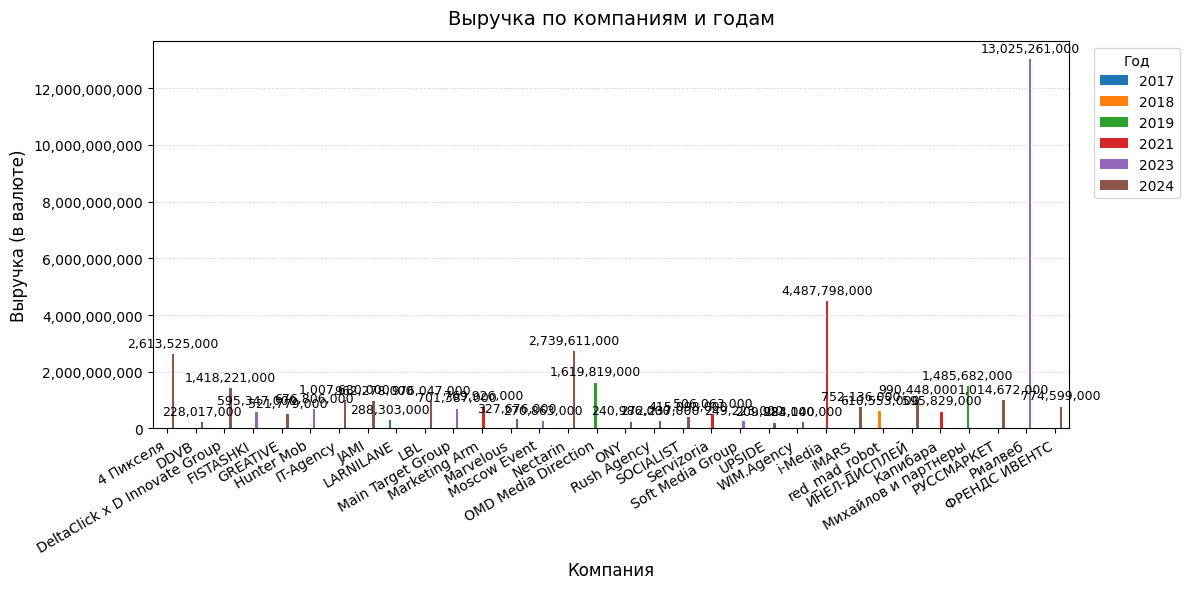

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np


# -----------------------
# подготовка: агрегируем выручку по (компания, год)
# -----------------------
pivot = (
    df_all_55
    .groupby(['name', 'revenue_year_x'], as_index=False)['revenue_x']
    .sum()
    .pivot(index='name', columns='revenue_year_x', values='revenue_x')
    .fillna(0)
)

# сортировка колонок по возрастанию года (необязательно)
pivot = pivot.reindex(sorted(pivot.columns), axis=1)

# -----------------------
# рисуем график: сгруппированные столбцы (каждая компания — одна группа)
# -----------------------
ax = pivot.plot(kind='bar', figsize=(12, 6))  # matplotlib автоматически подберет цвета
ax.set_title('Выручка по компаниям и годам', fontsize=14, pad=12)
ax.set_xlabel('Компания', fontsize=12)
ax.set_ylabel('Выручка (в валюте)', fontsize=12)

# форматирование y-оси (разделитель тысяч)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# показываем значения над столбцами
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v):,}' if v else '' for v in container.datavalues], padding=3, label_type='edge', fontsize=9)

# читаемые легенда и сетка
ax.legend(title='Год', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', linestyle=':', linewidth=0.7, alpha=0.7)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# -----------------------

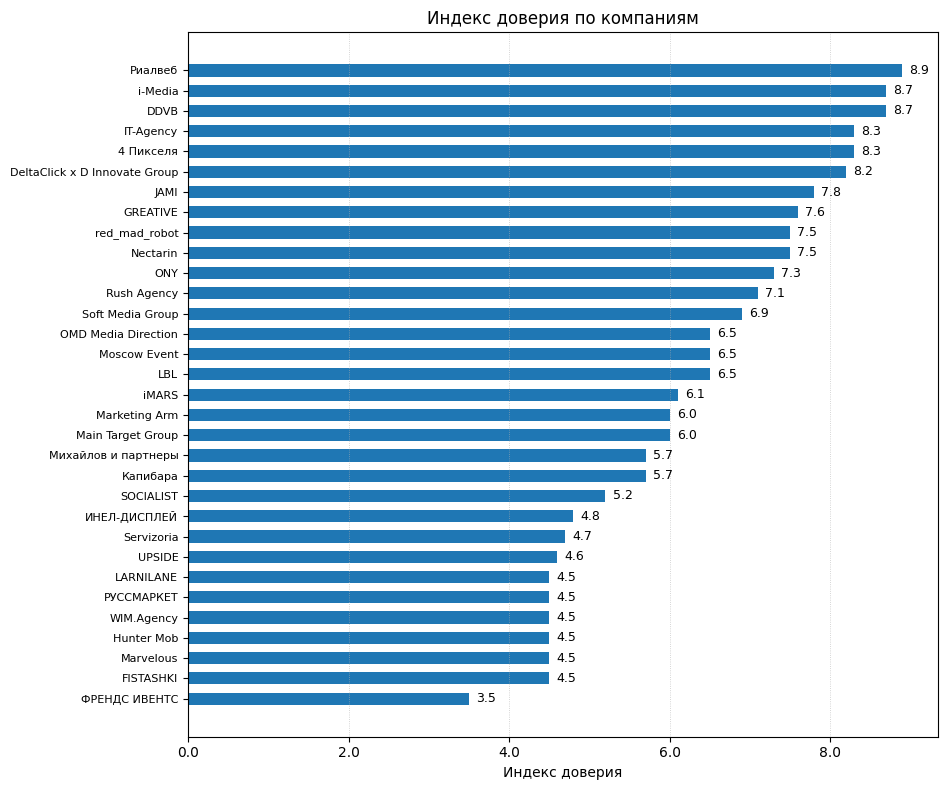

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter


# -----------------------
# защита от опечатки: если колонка называется 'index' — поддерживаем оба варианта
# -----------------------
if 'inddex' not in df_all_55.columns and 'index' in df_all_55.columns:
    df_all_55 = df_all_55.rename(columns={'index': 'inddex'})

# -----------------------
# очистка и агрегирование: если компании повторяются — берем средний индекс (или поменяй на .mean/.median/.max)
# -----------------------
plot_df_all_55 = (
    df_all_55[['name', 'inddex']]
    .dropna(subset=['name'])               # удалить строки без имени
    .copy()
)
# попытка привести inddex к числу
plot_df_all_55['inddex'] = pd.to_numeric(plot_df_all_55['inddex'], errors='coerce')
plot_df_all_55 = plot_df_all_55.dropna(subset=['inddex'])

# агрегируем (если по имени несколько записей)
plot_df_all_55 = plot_df_all_55.groupby('name', as_index=False)['inddex'].mean()

# сортируем по индексу (по убыванию — самые доверяемые наверху)
plot_df_all_55 = plot_df_all_55.sort_values('inddex', ascending=True)  # ascending=True для горизонтального графика (низ->вверх)

# -----------------------
# параметры фигуры (автоматическая высота)
# -----------------------
n = len(plot_df_all_55)
height_per_row = 0.25  # можно регулировать: меньше — компактнее, больше — просторнее
fig_height = max(4, height_per_row * n)
fig, ax = plt.subplots(figsize=(10, fig_height))

# -----------------------
# основной график: горизонтальные столбцы
# -----------------------
bars = ax.barh(plot_df_all_55['name'], plot_df_all_55['inddex'], height=0.6)

# подписи и форматирование
ax.set_xlabel('Индекс доверия')
ax.set_title('Индекс доверия по компаниям')
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))  # одна цифра после запятой

# подписи значений справа от баров
for bar in bars:
    w = bar.get_width()
    if np.isnan(w):
        label = ''
    else:
        label = f'{w:,.1f}'
    ax.text(w + (0.01 * max(plot_df_all_55['inddex'].max(), 1)),   # небольшое смещение вправо
            bar.get_y() + bar.get_height()/2,
            label,
            va='center', fontsize=9)

# удобства
plt.tight_layout()
ax.grid(axis='x', linestyle=':', linewidth=0.6, alpha=0.7)

# если названий слишком много — уменьшим шрифт
if n > 25:
    ax.tick_params(axis='y', labelsize=8)
elif n > 40:
    ax.tick_params(axis='y', labelsize=7)

plt.show()

